In [1]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [2]:
patients = [559]
windows = [6]
horizons = [1]



train_parameters = {
    'ohio_no': 559,
    'scope': 'train',
    'train_ds_size': 0,
    'window_size': 6,
    'prediction_horizon': 3,
    'minimal_features': False,
}

unseen_data_parameters = {
    'ohio_no': 559,
    'scope': 'test',
    'train_ds_size': 0,
    'window_size': 6,
    'prediction_horizon': 3,
    'minimal_features': False,
}

# output = run_experiment(parameters, test_parameters)

2021-07-01 07:51:32.023 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_train_0_6_3.pkl
2021-07-01 07:51:32.225 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'train', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 3, 'minimal_features': False}


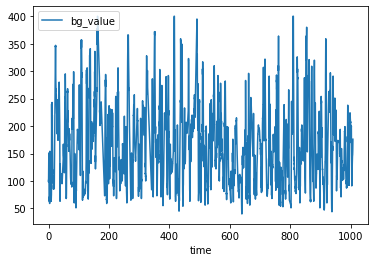

2021-07-01 07:51:32.702 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-01 07:51:32.703 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_train_0_6_3.pkl


In [3]:
source_df = create_tsfresh_dataframe(train_parameters)
clean_df = source_df.drop(
    columns=['start', 'end', 'start_time', 'end_time'])

In [4]:
regressor = setup(clean_df,
    target='label',
    feature_selection=True,
    html=True,
    silent=True,
    session_id=1974
    )

,Description,Value
0,session_id,1974
1,Target,label
2,Original Data,"(10788, 788)"
3,Missing Values,True
4,Numeric Features,260
5,Categorical Features,527
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(7551, 230)"


In [5]:
best3 = compare_models(
    exclude=['catboost', 'xgboost'],
    sort='RMSE',
    n_select=3,
    verbose=True
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,10.2412,286.6248,16.8048,0.9419,0.1063,0.0685,6.1470
lightgbm,Light Gradient Boosting Machine,10.2443,287.6089,16.8504,0.9417,0.1055,0.0677,1.0200
et,Extra Trees Regressor,10.1207,290.9515,16.9517,0.9411,0.1062,0.0671,12.4050
rf,Random Forest Regressor,10.1858,299.6038,17.2064,0.9393,0.1070,0.0672,16.8160
en,Elastic Net,10.4330,377.5017,19.0629,0.9236,0.1091,0.0693,0.3680
br,Bayesian Ridge,10.3866,393.0649,19.2927,0.9204,0.1081,0.0686,0.1990
lasso,Lasso Regression,10.4684,392.6329,19.4570,0.9209,0.1105,0.0698,0.3180
omp,Orthogonal Matching Pursuit,10.3995,483.3023,20.5678,0.9023,0.1171,0.0683,0.0380
ridge,Ridge Regression,10.5528,565.3176,22.0459,0.8874,0.1161,0.0701,0.0500
knn,K Neighbors Regressor,14.1246,493.7816,22.1788,0.9005,0.1428,0.0949,0.4900


In [6]:
best3

[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1974, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               ra

In [7]:
master_output = {}

In [8]:
def run_model(model_to_run):
    output = {}
    model = create_model(model_to_run)
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    (_, res) = clarke_error_grid(pd['label'], pd['Label'], 'Test')
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    (_, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], 'Test')
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
    logger.info(output)
    master_output[model_name] = output
    # df_array.append()
    

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.9828,353.4368,18.7999,0.9215,0.1208,0.0736
1,9.5437,191.6865,13.8451,0.9625,0.0931,0.0641
2,10.1397,262.8278,16.2120,0.9499,0.0988,0.0673
3,10.7742,354.1431,18.8187,0.9289,0.1106,0.0696
4,9.2876,181.1028,13.4574,0.9647,0.0874,0.0616
5,11.0809,303.7015,17.4270,0.9438,0.1131,0.0728
6,10.6058,346.8212,18.6231,0.9296,0.1188,0.0747
7,9.7341,239.9707,15.4910,0.9501,0.1058,0.0682
8,9.6531,250.4771,15.8265,0.9505,0.1029,0.0645
9,10.6103,382.0807,19.5469,0.9180,0.1117,0.0690


2021-07-01 08:01:39.773 | INFO     | __main__:run_model:5 - Processing model: GradientBoostingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.1243,262.9196,16.2148,0.9470,0.1024,0.0678


2021-07-01 08:01:40.149 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_3.pkl
2021-07-01 08:01:40.191 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 3, 'minimal_features': False}


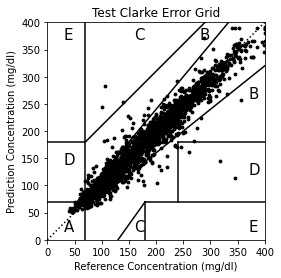

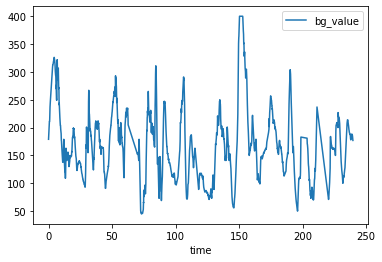

2021-07-01 08:01:40.529 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-01 08:01:40.530 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_3.pkl
2021-07-01 08:01:43.465 | INFO     | __main__:run_model:28 - {'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1974, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=F

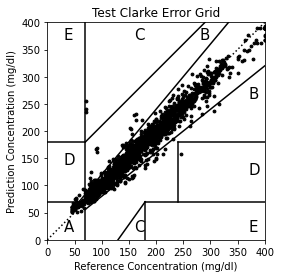

In [9]:
run_model(best3[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.8854,353.0227,18.7889,0.9216,0.1189,0.0715
1,9.9256,210.7479,14.5172,0.9588,0.0942,0.0652
2,9.9785,258.4273,16.0757,0.9508,0.0969,0.0653
3,10.7427,356.2447,18.8744,0.9285,0.1091,0.0677
4,9.4897,184.7453,13.5921,0.9639,0.0884,0.0627
5,10.7280,283.0649,16.8245,0.9476,0.1071,0.0693
6,10.3323,338.8662,18.4083,0.9312,0.1170,0.0726
7,9.9638,250.4063,15.8242,0.9479,0.1085,0.0694
8,9.8597,253.9413,15.9355,0.9498,0.1028,0.0655
9,10.5376,386.6226,19.6627,0.9170,0.1116,0.0674


2021-07-01 08:03:41.928 | INFO     | __main__:run_model:5 - Processing model: LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,10.0169,260.2805,16.1332,0.9476,0.1007,0.0662


2021-07-01 08:03:42.325 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_3.pkl
2021-07-01 08:03:42.349 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 3, 'minimal_features': False}


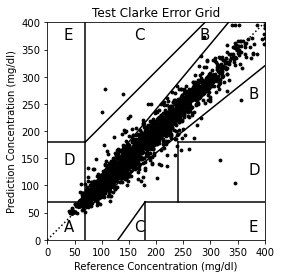

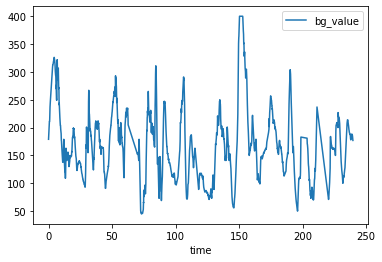

2021-07-01 08:03:42.700 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-01 08:03:42.700 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_3.pkl
2021-07-01 08:03:44.007 | INFO     | __main__:run_model:28 - {'model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1974, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), 'model_name': 'LGBMRegressor', 'internal_cga_analysis': [3080, 133, 3, 21, 0], 'internal_rmse': 16.133210859453765, 'internal_rmadex': 3156.5959057130494, 'unseen_cga_analysis': [2439, 57, 3, 7, 0], 'unseen

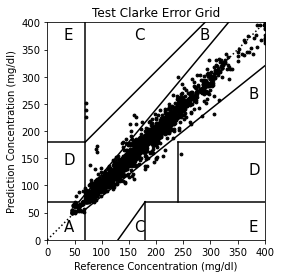

In [10]:
run_model(best3[1])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10.7346,350.6284,18.7251,0.9221,0.1184,0.0709
1,9.5869,207.5312,14.4059,0.9594,0.0944,0.0637
2,9.7859,251.6682,15.8641,0.9520,0.0970,0.0647
3,10.6242,355.8430,18.8638,0.9285,0.1084,0.0665
4,9.5237,194.8278,13.9581,0.9620,0.0904,0.0623
5,10.8382,304.5143,17.4503,0.9437,0.1110,0.0702
6,9.9885,331.7250,18.2133,0.9327,0.1142,0.0697
7,9.4492,237.6510,15.4159,0.9506,0.1058,0.0671
8,10.1184,282.0679,16.7949,0.9443,0.1087,0.0672
9,10.5572,393.0580,19.8257,0.9156,0.1139,0.0683


2021-07-01 08:05:57.875 | INFO     | __main__:run_model:5 - Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.1577,267.2515,16.3478,0.9462,0.1027,0.0676


2021-07-01 08:05:58.867 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/559_test_0_6_3.pkl
2021-07-01 08:05:58.913 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 559, 'scope': 'test', 'train_ds_size': 0, 'window_size': 6, 'prediction_horizon': 3, 'minimal_features': False}


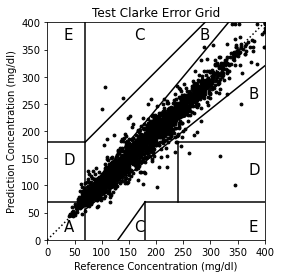

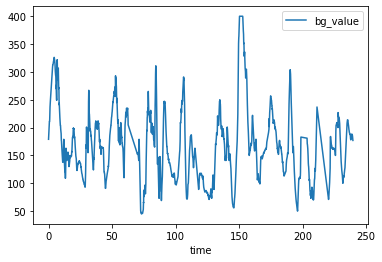

2021-07-01 08:05:59.492 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-01 08:05:59.494 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/559_test_0_6_3.pkl
2021-07-01 08:06:01.998 | INFO     | __main__:run_model:28 - {'model': ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1974, verbose=0, warm_start=False), 'model_name': 'ExtraTreesRegressor', 'internal_cga_analysis': [3058, 142, 3, 34, 0], 'internal_rmse': 16.34782980399716, 'internal_rmadex': 3693.5946650874284, 'unseen_cga_analy

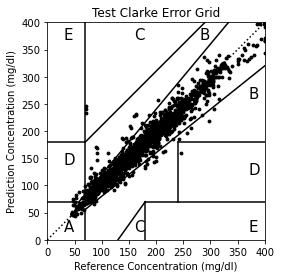

In [11]:
run_model(best3[2])

In [12]:
print(master_output)

{'GradientBoostingRegressor': {'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1974, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), 'model_name': 'GradientBoostingRegressor', 'internal_cga_analysis': [3053, 147, 3, 34, 0], 'internal_rmse': 16.21479446605164, 'internal_rmadex': 2267.2602897579463, 'unseen_cga_analysis': [2437, 57, 3, 9, 0], 'unseen_rmse': 13.384565771480466, 'unseen_rmadex': 179.90258864775075}, 'LGBMRegre

In [13]:
pandas.DataFrame.from_dict(master_output, orient='index')

,model,model_name,internal_cga_analysis,internal_rmse,internal_rmadex,unseen_cga_analysis,unseen_rmse,unseen_rmadex
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",GradientBoostingRegressor,"[3053, 147, 3, 34, 0]",16.214794,2267.260290,"[2437, 57, 3, 9, 0]",13.384566,179.902589
LGBMRegressor,"LGBMRegressor(boosting_type='gbdt', class_weig...",LGBMRegressor,"[3080, 133, 3, 21, 0]",16.133211,3156.595906,"[2439, 57, 3, 7, 0]",13.191126,162.475721
ExtraTreesRegressor,"(ExtraTreeRegressor(ccp_alpha=0.0, criterion='...",ExtraTreesRegressor,"[3058, 142, 3, 34, 0]",16.347830,3693.594665,"[2412, 78, 3, 13, 0]",14.169191,156.074509


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d560f233-0034-499f-bc4e-7ada8795cb9f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>